In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm
import torch.nn.functional as F
import tqdm
import PMLE
from imblearn.over_sampling import SMOTE
import datetime
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
import random
from keras import regularizers
from keras import models,layers,optimizers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt 
%matplotlib inline

# Data Preprocessing

In [6]:
df = pd.read_csv('creditcard.csv')

time_df = pd.DataFrame(df.Time)
time_df['hour_dummy']=(time_df.Time/(60*60)).round().astype(str)
time_df['day_dummy']=(time_df.Time/(60*60*24)).round().astype(str)
time_df = pd.get_dummies(time_df,drop_first=True).drop('Time',axis=1)
df.drop('Time',axis=1,inplace=True)

df['cents'] = df.Amount.apply(lambda x: int(str(x).split('.')[1]))
df.Amount[df.Amount!=0] = np.log(df.Amount[df.Amount!=0])

X = df.drop('Class',axis=1)
y = df.Class

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=0)
time_train, time_val = train_test_split(time_df,test_size=0.2,random_state=0)

# Obtain bagged logistic regression with penalized MLE results

In [3]:
def get_bagged_PMLE_results(X_train,y_train,functions,function_labels,iterations=20):
    train = dict.fromkeys(function_labels,np.zeros(X_train.shape[0]))
    val = dict.fromkeys(function_labels,np.zeros(X_val.shape[0]))
    for i in range(iterations):
        print('Epoch', i+1)
        X = X_train[y_train==1].sample(frac=0.05).append(X_train[y_train==0].sample(frac=0.05))
        y = y_train.loc[X.index]
        for j in range(len(functions)):
            functions[j].fit(X,y)
            train[function_labels[j]] = ((i)*train[function_labels[j]] + functions[j].predict_proba(X_train))/(i+1)
            val[function_labels[j]] =  ((i)*val[function_labels[j]] + functions[j].predict_proba(X_val))/(i+1)
    return train, val


In [ ]:
firth = PMLE.PMLE.Firth_Logit(num_iters=125,lr=0.05, metric='recall_score', readout_rate=10)
FLIC = PMLE.PMLE.Firth_Logit(num_iters=125,lr=0.05,FLIC=True, metric='recall_score', readout_rate=10)
t_firth = PMLE.PMLE.Firth_Logit(num_iters=125,lr=0.05,lmbda=0.01, metric='recall_score', readout_rate=10)

functions = [firth, FLIC, t_firth]
function_labels = ['firth','FLIC','t_firth']

train_results, val_results = get_bagged_PMLE_results(X_train,y_train,functions,function_labels,iterations=1)

train_results = pd.DataFrame.from_dict(train_results)
train_results.index = X_train.index
val_results = pd.DataFrame.from_dict(val_results)
val_results.index = X_val.index

# Autoencoder Anomaly Detection
### With undercomplete, regularized and denoising autoencoders using pytorch

## Data Processing

In [56]:
# identify non-fraud rows
normal_inds = y_train[y_train==0].reset_index().index

#Standardize dfs
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.fit_transform(X_val)
n_features = X_train_sc.shape[1]

#Convert non-fraud rows to pytorch tensor
normal_train = X_train_sc[normal_inds,:]
normal_torch = torch.from_numpy(normal_train,).type(torch.FloatTensor)

#Convert train and val sets to pytorch tensor
train_torch = torch.from_numpy(X_train_sc).type(torch.FloatTensor)
val_torch = torch.from_numpy(X_val_sc).type(torch.FloatTensor)

## Create autoencoder class 

In [57]:
class AutoEncoder(nn.Module):
    
    def __init__(self,n_features,hidden_nodes,dropout=None,VAE=False):
        
        '''PARAMATERS
           n_features: number of X variables in dataset
           hidden_nodes: number of nodes in hidden layer
           dropout: fraction of nodes to dropout (0 < dropout <1)'''
        
        super(AutoEncoder, self).__init__()
        self.n_features=n_features
        self.n_hidden = hidden_nodes
        self.encoder = nn.Linear(n_features,hidden_nodes)
        self.decoder = nn.Linear(hidden_nodes,n_features)
        self.output_layer = nn.Linear(n_features,n_features)
        self.dropout = dropout
        self.best_recon = None
        
        
    def forward (self,x):
        if self.dropout!=None:
            x = F.relu(F.dropout(self.encoder(x)))
        else:
            x = F.relu(self.encoder(x))
        self.hidden_layer=x
        x = F.relu(self.decoder(x))
        x = self.output_layer(x)
        return x
    
    

In [58]:
def train_autoencoder(model, dataset, loss_func, optimizer, epochs=100, batch_size=1024,  
                      validation_tensor=None,y_val=None, lr_rate_scheduler = None, noise_factor=None, 
                      random_seed=None, MSE_stopping_threshold=0):
        '''Parameters
           model: instantiated autoencoder
           dataset: torch tensor of X variables
           loss_func: instantiated loss function
           optimizer: instantiated optimizer
           validation_tensor: torch tensor of validation X variables
           y_val: numpy array of y values
           epochs: number of epochs
           lr_rate_scheduler: Instantiated PyTorch learning rate scheduler
           batch_size: batch_size
           noise_factor: magnitude of noise added to data
             for a denoising autoencoder (0 < noise_factor <=1)
           random_seed: random_seed
           stopping_MSE_threshold: MSE value after which autoencoder stops training'''

        
        #Set up
        if random_seed!=None:
            torch.manual_seed(random_seed)
        train_loader = torch.utils.data.DataLoader(dataset, 
                                                   batch_size=batch_size, 
                                                   shuffle=True)

        if type(validation_tensor)==torch.Tensor:
            val = True
            val_numpy = validation_tensor.detach().numpy()
        else:
            val = False

        readout_batch_interval = 0.25*(dataset.shape[0]/batch_size)//1
        
        #Training
        for epoch in range(epochs):
            counter = 0
            print('\n\033[1mEpoch {}\033[0m\n'.format(epoch+1))
            for batch in train_loader:

                if noise_factor!=None:
                    batch = batch + noise_factor * torch.randn(*batch.shape)
                batch = torch.autograd.Variable(batch)
                optimizer.zero_grad()
                recon = model(batch)
                loss = loss_func(recon, batch)
                if (counter%readout_batch_interval==0):
                    print('Batch {} Loss: {:.4f}'.format(counter, float(loss)))
                loss.backward()
                optimizer.step()
                counter+=1
            
            #Readout for each epoch
            if epoch==0:
                epoch_loss = loss_func(model(dataset), dataset)
                print('\nEPOCH {} LOSS: {:.4f}'.format(epoch+1, float(epoch_loss)))
            else:
                old_epoch_loss = epoch_loss
                epoch_loss = loss_func(model(dataset), dataset)
                print('\nEPOCH {} LOSS: {:.4f}'.format(epoch+1, float(epoch_loss)))
                
            if val == True:
                val_output = model(validation_tensor).detach().numpy()
                reconstruction_error = np.sqrt(np.power(val_output - val_numpy, 2)).sum(axis=1)
                reconstruction_error = sc.fit_transform(reconstruction_error.reshape(-1, 1))
                sklogit = LogisticRegression()
                if epoch==0:
                    sklogit.fit(reconstruction_error,y_val)
                    preds = sklogit.predict(reconstruction_error)
                    score = recall_score(y_val,preds)
                    model.best_recon=model.parameters()
                    model.best_pr = score
                    print('\nReconstruction error recall: {:.4f}'.format(score))
                else:
                    old_score = score
                    sklogit.fit(reconstruction_error,y_val)
                    preds = sklogit.predict(reconstruction_error)
                    score = recall_score(y_val,preds)
                    if score<old_score:
                        model.best_recon=model.parameters()
                        model.best_recall = score
                    print('\nReconstruction error recall {:.4f}'.format(score))
                    print('Change: {:.4f}%'.format(float((score-old_score)/old_score)))
            if type(scheduler)==torch.optim.lr_scheduler.ReduceLROnPlateau:
                scheduler.step(score) 
            if epoch_loss<=MSE_stopping_threshold:
                break

## Train Autoencoders

### Autoencoder I: Undercomplete with Dropout

#### Instantiate encoder and loss function

In [36]:
ae1 = AutoEncoder(n_features,int(n_features*1.5//1),dropout=0.3)
loss_func = nn.MSELoss()

#### Train autoencoder

In [38]:
#Start with high learning rate
optimizer = torch.optim.SGD(ae1.parameters(), lr=0.02, momentum=0.9,nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.9, patience=4, verbose=True)
train_autoencoder(model=ae1,
                   dataset=normal_torch,
                   loss_func=loss_func,
                   optimizer=optimizer,
                   batch_size=256,
                   epochs=100,
                   lr_rate_scheduler=scheduler,
                   validation_tensor=val_torch,
                   y_val = y_val)


Epoch 1

Batch 0 Loss: 1.4900
Batch 222 Loss: 0.8589
Batch 444 Loss: 0.9410
Batch 666 Loss: 0.8289
Batch 888 Loss: 0.7099

EPOCH 1 LOSS: 0.8892

Reconstruction error recall: 0.1485

Epoch 2

Batch 0 Loss: 0.7737
Batch 222 Loss: 0.9750
Batch 444 Loss: 1.0887
Batch 666 Loss: 0.7332
Batch 888 Loss: 0.8008

EPOCH 2 LOSS: 0.8883

Reconstruction error recall 0.1386
Change: -0.0667%

Epoch 3

Batch 0 Loss: 0.7950
Batch 222 Loss: 0.8598
Batch 444 Loss: 0.8896
Batch 666 Loss: 0.8075
Batch 888 Loss: 0.7872

EPOCH 3 LOSS: 0.8880

Reconstruction error recall 0.1188
Change: -0.1429%

Epoch 4

Batch 0 Loss: 1.0196
Batch 222 Loss: 0.8915
Batch 444 Loss: 0.7577
Batch 666 Loss: 0.8030
Batch 888 Loss: 0.9440

EPOCH 4 LOSS: 0.8878

Reconstruction error recall 0.1683
Change: 0.4167%

Epoch 5

Batch 0 Loss: 0.8061
Batch 222 Loss: 0.7351
Batch 444 Loss: 0.8013
Batch 666 Loss: 0.8537
Batch 888 Loss: 0.9079

EPOCH 5 LOSS: 0.8881

Reconstruction error recall 0.1089
Change: -0.3529%

Epoch 6

Batch 0 Loss: 0.7

Batch 0 Loss: 0.3832
Batch 222 Loss: 0.3299
Batch 444 Loss: 0.3109
Batch 666 Loss: 0.4096
Batch 888 Loss: 0.3200

EPOCH 39 LOSS: 0.3660

Reconstruction error recall 0.0594
Change: -0.1429%
Epoch    39: reducing learning rate of group 0 to 9.5659e-03.

Epoch 40

Batch 0 Loss: 0.3145
Batch 222 Loss: 0.3759
Batch 444 Loss: 0.3606
Batch 666 Loss: 0.4134
Batch 888 Loss: 0.2971

EPOCH 40 LOSS: 0.3626

Reconstruction error recall 0.0594
Change: 0.0000%

Epoch 41

Batch 0 Loss: 0.3436
Batch 222 Loss: 0.3546
Batch 444 Loss: 0.3113
Batch 666 Loss: 0.3416
Batch 888 Loss: 0.3593

EPOCH 41 LOSS: 0.3620

Reconstruction error recall 0.0495
Change: -0.1667%

Epoch 42

Batch 0 Loss: 0.3401
Batch 222 Loss: 0.3136
Batch 444 Loss: 0.3059
Batch 666 Loss: 0.4467
Batch 888 Loss: 0.3053

EPOCH 42 LOSS: 0.3599

Reconstruction error recall 0.0396
Change: -0.2000%

Epoch 43

Batch 0 Loss: 0.4845
Batch 222 Loss: 0.3181
Batch 444 Loss: 0.3436
Batch 666 Loss: 0.3325
Batch 888 Loss: 0.2859

EPOCH 43 LOSS: 0.3576

Re

Batch 222 Loss: 0.5397
Batch 444 Loss: 0.3343
Batch 666 Loss: 0.3153
Batch 888 Loss: 0.3083

EPOCH 76 LOSS: 0.3320

Reconstruction error recall 0.0495
Change: 0.0000%

Epoch 77

Batch 0 Loss: 0.3109
Batch 222 Loss: 0.3106
Batch 444 Loss: 0.3967
Batch 666 Loss: 0.3246
Batch 888 Loss: 0.3530

EPOCH 77 LOSS: 0.3317

Reconstruction error recall 0.0396
Change: -0.2000%

Epoch 78

Batch 0 Loss: 0.3665
Batch 222 Loss: 0.3123
Batch 444 Loss: 0.3017
Batch 666 Loss: 0.3230
Batch 888 Loss: 0.2849

EPOCH 78 LOSS: 0.3306

Reconstruction error recall 0.0297
Change: -0.2500%

Epoch 79

Batch 0 Loss: 0.3707
Batch 222 Loss: 0.4081
Batch 444 Loss: 0.2870
Batch 666 Loss: 0.3588
Batch 888 Loss: 0.3440

EPOCH 79 LOSS: 0.3309

Reconstruction error recall 0.0594
Change: 1.0000%
Epoch    79: reducing learning rate of group 0 to 4.1178e-03.

Epoch 80

Batch 0 Loss: 0.3151
Batch 222 Loss: 0.3304
Batch 444 Loss: 0.2774
Batch 666 Loss: 0.3049
Batch 888 Loss: 0.3757

EPOCH 80 LOSS: 0.3287

Reconstruction error rec

#### Save results

In [39]:
output1 = ae1(normal_torch)
train_output1 = ae1(train_torch)
val_output1 = ae1(val_torch)

### Autoencoder II: L2 Regularization

In [32]:
ae2 = AutoEncoder(n_features,n_features)
loss_func = nn.MSELoss()

In [42]:
optimizer = torch.optim.RMSprop(ae2.parameters(), lr=0.2, weight_decay=0.25)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, verbose=True)
train_autoencoder(model=ae2,
                   dataset=output1,
                   loss_func=loss_func,
                   optimizer=optimizer,
                   batch_size=256,
                   epochs=500,
                   validation_tensor=val_torch,
                   lr_rate_scheduler=scheduler,
                   y_val=y_val)


Epoch 1

Batch 0 Loss: 0.5115
Batch 222 Loss: 0.8374
Batch 444 Loss: 0.4493
Batch 666 Loss: 0.5553
Batch 888 Loss: 0.5016

EPOCH 1 LOSS: 0.6490

Reconstruction error recall: 0.2079

Epoch 2

Batch 0 Loss: 0.7040
Batch 222 Loss: 0.5675
Batch 444 Loss: 0.5542
Batch 666 Loss: 0.5440
Batch 888 Loss: 1.6456

EPOCH 2 LOSS: 0.6498

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 3

Batch 0 Loss: 0.5355
Batch 222 Loss: 0.5429
Batch 444 Loss: 0.5103
Batch 666 Loss: 0.6005
Batch 888 Loss: 0.7870

EPOCH 3 LOSS: 0.6548

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 4

Batch 0 Loss: 0.7061
Batch 222 Loss: 0.5226
Batch 444 Loss: 0.7563
Batch 666 Loss: 0.6665
Batch 888 Loss: 0.7538

EPOCH 4 LOSS: 0.6543

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch     4: reducing learning rate of group 0 to 1.8000e-01.

Epoch 5

Batch 0 Loss: 0.5517
Batch 222 Loss: 0.6649
Batch 444 Loss: 0.9220
Batch 666 Loss: 0.8240
Batch 888 Loss: 0.4064

EPOCH 5 LOSS: 0.6492

Reconstruction erro

Batch 888 Loss: 0.4321

EPOCH 37 LOSS: 0.6436

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch    37: reducing learning rate of group 0 to 5.6486e-02.

Epoch 38

Batch 0 Loss: 0.5327
Batch 222 Loss: 0.9532
Batch 444 Loss: 0.6344
Batch 666 Loss: 0.5251
Batch 888 Loss: 1.0807

EPOCH 38 LOSS: 0.6444

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 39

Batch 0 Loss: 0.5375
Batch 222 Loss: 0.5572
Batch 444 Loss: 0.5385
Batch 666 Loss: 0.4820
Batch 888 Loss: 1.1792

EPOCH 39 LOSS: 0.6441

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 40

Batch 0 Loss: 0.7576
Batch 222 Loss: 0.5244
Batch 444 Loss: 0.5185
Batch 666 Loss: 0.5095
Batch 888 Loss: 0.5638

EPOCH 40 LOSS: 0.6440

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch    40: reducing learning rate of group 0 to 5.0837e-02.

Epoch 41

Batch 0 Loss: 0.4971
Batch 222 Loss: 0.7727
Batch 444 Loss: 0.7027
Batch 666 Loss: 0.5498
Batch 888 Loss: 0.4948

EPOCH 41 LOSS: 0.6438

Reconstruction error recall 0.207

Batch 888 Loss: 0.5774

EPOCH 73 LOSS: 0.6429

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch    73: reducing learning rate of group 0 to 1.5953e-02.

Epoch 74

Batch 0 Loss: 0.7559
Batch 222 Loss: 0.5803
Batch 444 Loss: 0.5087
Batch 666 Loss: 0.5226
Batch 888 Loss: 0.5133

EPOCH 74 LOSS: 0.6429

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 75

Batch 0 Loss: 0.6443
Batch 222 Loss: 0.4779
Batch 444 Loss: 0.7026
Batch 666 Loss: 0.5251
Batch 888 Loss: 1.1018

EPOCH 75 LOSS: 0.6431

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 76

Batch 0 Loss: 0.5662
Batch 222 Loss: 0.8769
Batch 444 Loss: 0.8016
Batch 666 Loss: 0.6007
Batch 888 Loss: 0.6057

EPOCH 76 LOSS: 0.6429

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch    76: reducing learning rate of group 0 to 1.4358e-02.

Epoch 77

Batch 0 Loss: 0.6362
Batch 222 Loss: 0.6411
Batch 444 Loss: 0.6095
Batch 666 Loss: 0.5535
Batch 888 Loss: 0.7551

EPOCH 77 LOSS: 0.6429

Reconstruction error recall 0.207

Batch 888 Loss: 0.7435

EPOCH 109 LOSS: 0.6427

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch   109: reducing learning rate of group 0 to 4.5057e-03.

Epoch 110

Batch 0 Loss: 0.9641
Batch 222 Loss: 0.7151
Batch 444 Loss: 0.5050
Batch 666 Loss: 0.7241
Batch 888 Loss: 0.4268

EPOCH 110 LOSS: 0.6427

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 111

Batch 0 Loss: 0.7105
Batch 222 Loss: 0.5884
Batch 444 Loss: 0.4775
Batch 666 Loss: 0.7176
Batch 888 Loss: 0.5570

EPOCH 111 LOSS: 0.6427

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 112

Batch 0 Loss: 0.6266
Batch 222 Loss: 0.6988
Batch 444 Loss: 0.6759
Batch 666 Loss: 0.5051
Batch 888 Loss: 0.4682

EPOCH 112 LOSS: 0.6427

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch   112: reducing learning rate of group 0 to 4.0551e-03.

Epoch 113

Batch 0 Loss: 0.5975
Batch 222 Loss: 0.4967
Batch 444 Loss: 0.5474
Batch 666 Loss: 0.5409
Batch 888 Loss: 0.4442

EPOCH 113 LOSS: 0.6427

Reconstruction error rec

Batch 222 Loss: 0.5621
Batch 444 Loss: 0.5781
Batch 666 Loss: 0.4696
Batch 888 Loss: 0.5828

EPOCH 145 LOSS: 0.6427

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch   145: reducing learning rate of group 0 to 1.2725e-03.

Epoch 146

Batch 0 Loss: 0.5743
Batch 222 Loss: 1.1410
Batch 444 Loss: 0.5185
Batch 666 Loss: 0.5530
Batch 888 Loss: 0.5931

EPOCH 146 LOSS: 0.6427

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 147

Batch 0 Loss: 0.6542
Batch 222 Loss: 0.4474
Batch 444 Loss: 0.5660
Batch 666 Loss: 0.5288
Batch 888 Loss: 1.0083

EPOCH 147 LOSS: 0.6427

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 148

Batch 0 Loss: 0.6147
Batch 222 Loss: 0.5847
Batch 444 Loss: 0.7350
Batch 666 Loss: 0.7062
Batch 888 Loss: 0.5060

EPOCH 148 LOSS: 0.6427

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch   148: reducing learning rate of group 0 to 1.1453e-03.

Epoch 149

Batch 0 Loss: 0.6205
Batch 222 Loss: 0.6583
Batch 444 Loss: 0.5220
Batch 666 Loss: 0.8312
Bat

Batch 222 Loss: 0.6731
Batch 444 Loss: 0.6053
Batch 666 Loss: 0.5548
Batch 888 Loss: 0.4276

EPOCH 181 LOSS: 0.6427

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch   181: reducing learning rate of group 0 to 3.5940e-04.

Epoch 182

Batch 0 Loss: 0.5821
Batch 222 Loss: 0.6065
Batch 444 Loss: 1.4900
Batch 666 Loss: 0.5691
Batch 888 Loss: 0.9073

EPOCH 182 LOSS: 0.6427

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 183

Batch 0 Loss: 0.6144
Batch 222 Loss: 0.5540
Batch 444 Loss: 0.6311
Batch 666 Loss: 0.5759
Batch 888 Loss: 0.6574

EPOCH 183 LOSS: 0.6427

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 184

Batch 0 Loss: 0.9939
Batch 222 Loss: 0.5264
Batch 444 Loss: 0.6228
Batch 666 Loss: 0.7631
Batch 888 Loss: 0.4634

EPOCH 184 LOSS: 0.6427

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch   184: reducing learning rate of group 0 to 3.2346e-04.

Epoch 185

Batch 0 Loss: 0.6686
Batch 222 Loss: 0.5573
Batch 444 Loss: 0.5228
Batch 666 Loss: 0.5562
Bat

KeyboardInterrupt: 

In [43]:
output2 = ae2(output1)
train_output2 = ae2(train_output1)
val_output2 = ae2(val_output1)

### Autoencoder III: Denoising

In [46]:
ae3 = AutoEncoder(n_features,n_features)
loss_func = nn.MSELoss()

In [47]:
optimizer = torch.optim.SGD(ae3.parameters(), lr=0.2,momentum=0.9,nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, verbose=True)
train_autoencoder(model=ae3,
                  dataset=output2,
                  loss_func=loss_func,
                  optimizer=optimizer,
                  batch_size=512,
                  epochs=10,
                  noise_factor=0.9,
                  validation_tensor=val_torch,
                  y_val=y_val)


Epoch 1

Batch 0 Loss: 0.8330
Batch 111 Loss: 0.2692
Batch 222 Loss: 0.1376
Batch 333 Loss: 0.1046
Batch 444 Loss: 0.0595

EPOCH 1 LOSS: 0.0040

Reconstruction error recall: 0.0198

Epoch 2

Batch 0 Loss: 0.0651
Batch 111 Loss: 0.0738
Batch 222 Loss: 0.0679
Batch 333 Loss: 0.0576
Batch 444 Loss: 0.0553

EPOCH 2 LOSS: 0.0004

Reconstruction error recall 0.0198
Change: 0.0000%

Epoch 3

Batch 0 Loss: 0.0536
Batch 111 Loss: 0.0546
Batch 222 Loss: 0.0558
Batch 333 Loss: 0.2186
Batch 444 Loss: 0.0683

EPOCH 3 LOSS: 0.0004

Reconstruction error recall 0.0198
Change: 0.0000%

Epoch 4

Batch 0 Loss: 0.0587
Batch 111 Loss: 0.0593
Batch 222 Loss: 0.0629
Batch 333 Loss: 0.0516
Batch 444 Loss: 0.0464

EPOCH 4 LOSS: 0.0001

Reconstruction error recall 0.0198
Change: 0.0000%
Epoch     4: reducing learning rate of group 0 to 1.8000e-01.

Epoch 5

Batch 0 Loss: 0.0489
Batch 111 Loss: 0.0498
Batch 222 Loss: 0.0509
Batch 333 Loss: 0.0508
Batch 444 Loss: 0.0556

EPOCH 5 LOSS: 0.0008

Reconstruction erro

In [48]:
output3 = ae3(output2)
train_output3 = ae3(train_output2)
val_output3 = ae3(val_output2)

### Autoencoder IV: L1 Regularization

In [49]:
ae4 = AutoEncoder(n_features,n_features)

def L1_loss(recon,inputs):
    MSELoss = nn.MSELoss()
    loss = MSELoss(recon,inputs)
    for param in ae4.parameters():
        loss += lmbda*torch.sum(torch.abs(param))
    return loss

loss_func = L1_loss

In [52]:
lmbda=0.25
optimizer = torch.optim.SGD(ae4.parameters(), lr=0.02,momentum=0.9,nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, verbose=True)
train_autoencoder(model=ae4,
                  dataset=output3,
                  loss_func=loss_func,
                  optimizer=optimizer,
                  batch_size=512,
                  epochs=200,
                  validation_tensor=val_torch,
                  y_val=y_val)


Epoch 1

Batch 0 Loss: 14.8840
Batch 111 Loss: 4.4161
Batch 222 Loss: 2.8226
Batch 333 Loss: 4.5036
Batch 444 Loss: 2.8294

EPOCH 1 LOSS: 5.3624

Reconstruction error recall: 0.2079

Epoch 2

Batch 0 Loss: 5.3624
Batch 111 Loss: 2.8056
Batch 222 Loss: 5.4804
Batch 333 Loss: 2.6617
Batch 444 Loss: 5.2765

EPOCH 2 LOSS: 3.3646

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 3

Batch 0 Loss: 3.3646
Batch 111 Loss: 5.0493
Batch 222 Loss: 3.3831
Batch 333 Loss: 4.9237
Batch 444 Loss: 3.3378

EPOCH 3 LOSS: 4.5558

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 4

Batch 0 Loss: 4.5558
Batch 111 Loss: 2.8863
Batch 222 Loss: 4.6447
Batch 333 Loss: 2.8796
Batch 444 Loss: 4.4702

EPOCH 4 LOSS: 2.9122

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch     4: reducing learning rate of group 0 to 1.8000e-02.

Epoch 5

Batch 0 Loss: 2.9122
Batch 111 Loss: 4.8211
Batch 222 Loss: 2.5176
Batch 333 Loss: 4.7899
Batch 444 Loss: 2.4808

EPOCH 5 LOSS: 4.5560

Reconstruction err

Batch 444 Loss: 1.0322

EPOCH 37 LOSS: 1.4880

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch    37: reducing learning rate of group 0 to 5.6486e-03.

Epoch 38

Batch 0 Loss: 1.4880
Batch 111 Loss: 0.8611
Batch 222 Loss: 1.3516
Batch 333 Loss: 0.8455
Batch 444 Loss: 1.3007

EPOCH 38 LOSS: 0.8287

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 39

Batch 0 Loss: 0.8287
Batch 111 Loss: 1.3905
Batch 222 Loss: 0.8394
Batch 333 Loss: 1.4246
Batch 444 Loss: 0.8678

EPOCH 39 LOSS: 1.4004

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 40

Batch 0 Loss: 1.4004
Batch 111 Loss: 0.9065
Batch 222 Loss: 1.4385
Batch 333 Loss: 0.8729
Batch 444 Loss: 1.4523

EPOCH 40 LOSS: 0.8644

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch    40: reducing learning rate of group 0 to 5.0837e-03.

Epoch 41

Batch 0 Loss: 0.8644
Batch 111 Loss: 1.2067
Batch 222 Loss: 0.7708
Batch 333 Loss: 1.1845
Batch 444 Loss: 0.7687

EPOCH 41 LOSS: 1.2847

Reconstruction error recall 0.207

Batch 444 Loss: 0.2745

EPOCH 73 LOSS: 0.4386

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch    73: reducing learning rate of group 0 to 1.5953e-03.

Epoch 74

Batch 0 Loss: 0.4386
Batch 111 Loss: 0.2430
Batch 222 Loss: 0.3932
Batch 333 Loss: 0.2399
Batch 444 Loss: 0.3902

EPOCH 74 LOSS: 0.2464

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 75

Batch 0 Loss: 0.2464
Batch 111 Loss: 0.3954
Batch 222 Loss: 0.2478
Batch 333 Loss: 0.3943
Batch 444 Loss: 0.2514

EPOCH 75 LOSS: 0.3904

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 76

Batch 0 Loss: 0.3904
Batch 111 Loss: 0.2487
Batch 222 Loss: 0.3936
Batch 333 Loss: 0.2431
Batch 444 Loss: 0.4021

EPOCH 76 LOSS: 0.2406

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch    76: reducing learning rate of group 0 to 1.4358e-03.

Epoch 77

Batch 0 Loss: 0.2406
Batch 111 Loss: 0.3612
Batch 222 Loss: 0.2196
Batch 333 Loss: 0.3509
Batch 444 Loss: 0.2165

EPOCH 77 LOSS: 0.3632

Reconstruction error recall 0.207

Batch 444 Loss: 0.0776

EPOCH 109 LOSS: 0.1247

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch   109: reducing learning rate of group 0 to 4.5057e-04.

Epoch 110

Batch 0 Loss: 0.1247
Batch 111 Loss: 0.0680
Batch 222 Loss: 0.1108
Batch 333 Loss: 0.0696
Batch 444 Loss: 0.1080

EPOCH 110 LOSS: 0.0698

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 111

Batch 0 Loss: 0.0698
Batch 111 Loss: 0.1119
Batch 222 Loss: 0.0703
Batch 333 Loss: 0.1124
Batch 444 Loss: 0.0707

EPOCH 111 LOSS: 0.1119

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 112

Batch 0 Loss: 0.1119
Batch 111 Loss: 0.0721
Batch 222 Loss: 0.1128
Batch 333 Loss: 0.0680
Batch 444 Loss: 0.1145

EPOCH 112 LOSS: 0.0682

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch   112: reducing learning rate of group 0 to 4.0551e-04.

Epoch 113

Batch 0 Loss: 0.0682
Batch 111 Loss: 0.1017
Batch 222 Loss: 0.0637
Batch 333 Loss: 0.0971
Batch 444 Loss: 0.0617

EPOCH 113 LOSS: 0.1013

Reconstruction error rec

Batch 111 Loss: 0.0347
Batch 222 Loss: 0.0228
Batch 333 Loss: 0.0341
Batch 444 Loss: 0.0218

EPOCH 145 LOSS: 0.0354

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch   145: reducing learning rate of group 0 to 1.2725e-04.

Epoch 146

Batch 0 Loss: 0.0354
Batch 111 Loss: 0.0193
Batch 222 Loss: 0.0316
Batch 333 Loss: 0.0199
Batch 444 Loss: 0.0308

EPOCH 146 LOSS: 0.0198

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 147

Batch 0 Loss: 0.0198
Batch 111 Loss: 0.0310
Batch 222 Loss: 0.0205
Batch 333 Loss: 0.0316
Batch 444 Loss: 0.0203

EPOCH 147 LOSS: 0.0314

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 148

Batch 0 Loss: 0.0314
Batch 111 Loss: 0.0205
Batch 222 Loss: 0.0315
Batch 333 Loss: 0.0193
Batch 444 Loss: 0.0324

EPOCH 148 LOSS: 0.0199

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch   148: reducing learning rate of group 0 to 1.1453e-04.

Epoch 149

Batch 0 Loss: 0.0199
Batch 111 Loss: 0.0290
Batch 222 Loss: 0.0179
Batch 333 Loss: 0.0278
Bat

KeyboardInterrupt: 

In [53]:
output4 = ae4(output3)
train_output4 = ae4(train_output3)
val_output4 = ae4(val_output3)

### Autoencoder V: Kitchen Sink

In [61]:
ae5 = AutoEncoder(n_features,int(n_features//4),dropout=0.5)
loss_func = L1_loss

In [62]:
optimizer = torch.optim.RMSprop(ae5.parameters(), lr=0.02, weight_decay=0.5)
train_autoencoder(model=ae5,
                  dataset=output4,
                  loss_func=loss_func,
                  optimizer=optimizer,
                  batch_size=1024,
                  epochs=200,
                  noise_factor=0.5,
                  validation_tensor=val_torch,
                  y_val=y_val)


Epoch 1

Batch 0 Loss: 0.3079
Batch 55 Loss: 0.2757
Batch 110 Loss: 0.2761
Batch 165 Loss: 0.2779
Batch 220 Loss: 0.2804

EPOCH 1 LOSS: 0.0281

Reconstruction error recall: 0.2079

Epoch 2

Batch 0 Loss: 0.2761
Batch 55 Loss: 0.2778
Batch 110 Loss: 0.2804
Batch 165 Loss: 0.2748
Batch 220 Loss: 0.2793

EPOCH 2 LOSS: 0.0281

Reconstruction error recall 0.2079
Change: 0.0000%
Epoch   163: reducing learning rate of group 0 to 6.7628e-05.

Epoch 3

Batch 0 Loss: 0.2768
Batch 55 Loss: 0.2819
Batch 110 Loss: 0.2805
Batch 165 Loss: 0.2801
Batch 220 Loss: 0.2792

EPOCH 3 LOSS: 0.0280

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 4

Batch 0 Loss: 0.2782
Batch 55 Loss: 0.2770
Batch 110 Loss: 0.2773
Batch 165 Loss: 0.2768
Batch 220 Loss: 0.2766

EPOCH 4 LOSS: 0.0280

Reconstruction error recall 0.2079
Change: 0.0000%

Epoch 5

Batch 0 Loss: 0.2761
Batch 55 Loss: 0.2778
Batch 110 Loss: 0.2772
Batch 165 Loss: 0.2763
Batch 220 Loss: 0.2799

EPOCH 5 LOSS: 0.0281

Reconstruction error rec

KeyboardInterrupt: 

In [63]:
output5 = ae5(output4)
train_output5 = ae5(train_output4)
val_output5 = ae5(val_output4)

### Add reconstruction score to DFs

In [69]:
final_train_output = train_output5.detach().numpy()
final_val_output = val_output5.detach().numpy()

#calculate reconstruction score
train_reconstruction_score = np.power(X_train_sc - final_train_output,2).sum(axis=1)
train_reconstruction score = train_reconstruction_score/(train_reconstruction_score.max()-train_reconstruction_score.min())
val_reconstruction_score = np.power(X_val_sc - final_val_output,2).sum(axis=1)
val_reconstruction score = val_reconstruction_score/(val_reconstruction_score.max()-val_reconstruction_score.min())
train_results['recon_score']=train_reconstruction_score
val_results['recon_score']= val_reconstruction_score

# Logistic Regression with L2 regularization on SMOTE data

In [59]:
smote = SMOTE(n_jobs=-1)
smote_train_X, smote_train_y = smote.fit_resample(X_train,y_train)
sklearn = LogisticRegression()
sklearn.fit(smote_train_X,smote_train_y)
train_results['smote']=sklearn.predict_proba(X_train)[:,1]
val_results['smote']=sklearn.predict_proba(X_val)[:,1]

# Class-Weighted MLP

### Add time data to columns

In [7]:
X_train = X_train.join(time_df)
X_val = X_val.join(time_df)

### Preprocess data

In [65]:
y_train_keras = to_categorical(y_train)
y_val_keras = to_categorical(y_val)
class_weights = {0:1,1:1/y_train.mean()}

In [66]:
sc = StandardScaler()
X_train_keras = sc.fit_transform(X_train)
X_val_keras = sc.fit_transform(X_val)

### Set checkpoint and learning rate scheduler

In [67]:
scheduler = ReduceLROnPlateau(monitor='loss',
                                factor=0.8, 
                                patience=10, 
                                verbose=1,
                                mode='auto', 
                                min_delta=0.0001, 
                                cooldown=0, 
                                min_lr=0)
checkpoint = ModelCheckpoint('checkpoint.best.hdf5',  verbose=1, save_best_only=True, mode='auto')

### Instantiate and compile MLP

In [68]:
nn = models.Sequential()
nn.add(layers.Dropout(.3))
nn.add(layers.Dense(128, input_shape=(val_results.shape[1],), activation='relu'))
nn.add(layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
nn.add(layers.Dropout(.3))
nn.add(layers.Dense(32,activation='relu'))
nn.add(layers.Dense(16,activation='relu'))
nn.add(layers.Dropout(.3))
nn.add(layers.Dense(8,activation='relu'))
nn.add(layers.Dense(4,activation='relu'))
nn.add(layers.Dense(2,activation='sigmoid'))
nn.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
nn = models.Sequential()
nn.add(layers.Dropout(.3))
nn.add(layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
nn.add(layers.Dropout(.3))
nn.add(layers.Dense(32,activation='relu'))
nn.add(layers.Dense(16,activation='relu'))
nn.add(layers.Dropout(.3))
nn.add(layers.Dense(8,activation='relu'))
nn.add(layers.Dense(4,activation='relu'))
nn.add(layers.Dense(2,activation='sigmoid'))
nn.compile(loss='binary_crossentropy', optimizer='adam')

## Train MLP

In [69]:
nn.fit(train_results.values, 
       y_train_keras, 
       epochs=1000, 
       class_weight=class_weights,
       batch_size=512,
       validation_data=(val_results.values,y_val_keras),
       callbacks=[scheduler,checkpoint])

Train on 227845 samples, validate on 56962 samples
Epoch 1/1000
227845/227845 [==============================] - 6s 24us/step - loss: 0.8567 - val_loss: 0.1358

Epoch 00001: val_loss improved from inf to 0.13583, saving model to checkpoint.best.hdf5
Epoch 2/1000
227845/227845 [==============================] - 4s 18us/step - loss: 0.3642 - val_loss: 0.1089

Epoch 00002: val_loss improved from 0.13583 to 0.10887, saving model to checkpoint.best.hdf5
Epoch 3/1000
227845/227845 [==============================] - 4s 19us/step - loss: 0.3368 - val_loss: 0.2072

Epoch 00003: val_loss did not improve from 0.10887
Epoch 4/1000
227845/227845 [==============================] - 4s 19us/step - loss: 0.3068 - val_loss: 0.0806

Epoch 00004: val_loss improved from 0.10887 to 0.08056, saving model to checkpoint.best.hdf5
Epoch 5/1000
227845/227845 [==============================] - 4s 19us/step - loss: 0.3132 - val_loss: 0.0860

Epoch 00005: val_loss did not improve from 0.08056
Epoch 6/1000
227845/22

227845/227845 [==============================] - 5s 23us/step - loss: 0.2022 - val_loss: 0.0436

Epoch 00048: val_loss did not improve from 0.02737
Epoch 49/1000
227845/227845 [==============================] - 5s 23us/step - loss: 0.2229 - val_loss: 0.0502

Epoch 00049: val_loss did not improve from 0.02737
Epoch 50/1000
227845/227845 [==============================] - 5s 23us/step - loss: 0.2137 - val_loss: 0.0439

Epoch 00050: val_loss did not improve from 0.02737
Epoch 51/1000
227845/227845 [==============================] - 5s 22us/step - loss: 0.2087 - val_loss: 0.0531

Epoch 00051: val_loss did not improve from 0.02737
Epoch 52/1000
227845/227845 [==============================] - 5s 23us/step - loss: 0.1741 - val_loss: 0.0565

Epoch 00052: val_loss did not improve from 0.02737
Epoch 53/1000
227845/227845 [==============================] - 5s 24us/step - loss: 0.2148 - val_loss: 0.0454

Epoch 00053: val_loss did not improve from 0.02737
Epoch 54/1000
227845/227845 [=============


Epoch 00096: val_loss did not improve from 0.01987
Epoch 97/1000
227845/227845 [==============================] - 6s 26us/step - loss: 0.2022 - val_loss: 0.0399

Epoch 00097: val_loss did not improve from 0.01987
Epoch 98/1000
227845/227845 [==============================] - 6s 26us/step - loss: 0.2012 - val_loss: 0.0452

Epoch 00098: val_loss did not improve from 0.01987
Epoch 99/1000
227845/227845 [==============================] - 6s 26us/step - loss: 0.1539 - val_loss: 0.0338

Epoch 00099: val_loss did not improve from 0.01987
Epoch 100/1000
227845/227845 [==============================] - 6s 27us/step - loss: 0.1825 - val_loss: 0.0342

Epoch 00100: val_loss did not improve from 0.01987
Epoch 101/1000
227845/227845 [==============================] - 6s 26us/step - loss: 0.1645 - val_loss: 0.0219

Epoch 00101: val_loss did not improve from 0.01987
Epoch 102/1000
227845/227845 [==============================] - 6s 25us/step - loss: 0.2227 - val_loss: 0.0429

Epoch 00102: val_loss di

227845/227845 [==============================] - 6s 26us/step - loss: 0.1627 - val_loss: 0.0263

Epoch 00145: val_loss did not improve from 0.01987
Epoch 146/1000
227845/227845 [==============================] - 6s 25us/step - loss: 0.1740 - val_loss: 0.0232

Epoch 00146: ReduceLROnPlateau reducing learning rate to 0.00010737419361248613.

Epoch 00146: val_loss did not improve from 0.01987
Epoch 147/1000
227845/227845 [==============================] - 6s 25us/step - loss: 0.1686 - val_loss: 0.0266

Epoch 00147: val_loss did not improve from 0.01987
Epoch 148/1000
227845/227845 [==============================] - 6s 26us/step - loss: 0.1836 - val_loss: 0.0249

Epoch 00148: val_loss did not improve from 0.01987
Epoch 149/1000
227845/227845 [==============================] - 6s 26us/step - loss: 0.1794 - val_loss: 0.0235

Epoch 00149: val_loss did not improve from 0.01987
Epoch 150/1000
227845/227845 [==============================] - 6s 26us/step - loss: 0.1823 - val_loss: 0.0284

Epoch 


Epoch 00192: val_loss did not improve from 0.01833
Epoch 193/1000
227845/227845 [==============================] - 6s 26us/step - loss: 0.1768 - val_loss: 0.0253

Epoch 00193: val_loss did not improve from 0.01833
Epoch 194/1000
227845/227845 [==============================] - 6s 27us/step - loss: 0.1747 - val_loss: 0.0239

Epoch 00194: val_loss did not improve from 0.01833
Epoch 195/1000
227845/227845 [==============================] - 6s 27us/step - loss: 0.1654 - val_loss: 0.0228

Epoch 00195: val_loss did not improve from 0.01833
Epoch 196/1000
227845/227845 [==============================] - 6s 27us/step - loss: 0.1757 - val_loss: 0.0265

Epoch 00196: val_loss did not improve from 0.01833
Epoch 197/1000
227845/227845 [==============================] - 6s 27us/step - loss: 0.1918 - val_loss: 0.0305

Epoch 00197: val_loss did not improve from 0.01833
Epoch 198/1000
227845/227845 [==============================] - 6s 26us/step - loss: 0.1927 - val_loss: 0.0289

Epoch 00198: val_loss

227845/227845 [==============================] - 6s 26us/step - loss: 0.1733 - val_loss: 0.0230

Epoch 00241: val_loss did not improve from 0.01824
Epoch 242/1000
227845/227845 [==============================] - 6s 26us/step - loss: 0.1631 - val_loss: 0.0228

Epoch 00242: ReduceLROnPlateau reducing learning rate to 1.8014399392995985e-05.

Epoch 00242: val_loss did not improve from 0.01824
Epoch 243/1000
227845/227845 [==============================] - 6s 26us/step - loss: 0.1618 - val_loss: 0.0227

Epoch 00243: val_loss did not improve from 0.01824
Epoch 244/1000
227845/227845 [==============================] - 6s 25us/step - loss: 0.1473 - val_loss: 0.0220

Epoch 00244: val_loss did not improve from 0.01824
Epoch 245/1000
227845/227845 [==============================] - 5s 23us/step - loss: 0.1698 - val_loss: 0.0219

Epoch 00245: val_loss did not improve from 0.01824
Epoch 246/1000
227845/227845 [==============================] - 5s 23us/step - loss: 0.1533 - val_loss: 0.0207

Epoch 

227845/227845 [==============================] - 5s 23us/step - loss: 0.1383 - val_loss: 0.0190

Epoch 00289: val_loss did not improve from 0.01824
Epoch 290/1000
227845/227845 [==============================] - 5s 22us/step - loss: 0.1775 - val_loss: 0.0198

Epoch 00290: val_loss did not improve from 0.01824
Epoch 291/1000
227845/227845 [==============================] - 5s 22us/step - loss: 0.1512 - val_loss: 0.0201

Epoch 00291: val_loss did not improve from 0.01824
Epoch 292/1000
227845/227845 [==============================] - 5s 22us/step - loss: 0.1905 - val_loss: 0.0207

Epoch 00292: ReduceLROnPlateau reducing learning rate to 5.902958946535364e-06.

Epoch 00292: val_loss did not improve from 0.01824
Epoch 293/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1802 - val_loss: 0.0215

Epoch 00293: val_loss did not improve from 0.01824
Epoch 294/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1789 - val_loss: 0.0212

Epoch 0

227845/227845 [==============================] - 5s 22us/step - loss: 0.1615 - val_loss: 0.0215

Epoch 00337: val_loss did not improve from 0.01824
Epoch 338/1000
227845/227845 [==============================] - 5s 22us/step - loss: 0.1520 - val_loss: 0.0214

Epoch 00338: val_loss did not improve from 0.01824
Epoch 339/1000
227845/227845 [==============================] - 5s 22us/step - loss: 0.1488 - val_loss: 0.0212

Epoch 00339: val_loss did not improve from 0.01824
Epoch 340/1000
227845/227845 [==============================] - 5s 22us/step - loss: 0.1772 - val_loss: 0.0214

Epoch 00340: val_loss did not improve from 0.01824
Epoch 341/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1386 - val_loss: 0.0211

Epoch 00341: val_loss did not improve from 0.01824
Epoch 342/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1731 - val_loss: 0.0213

Epoch 00342: ReduceLROnPlateau reducing learning rate to 1.9342816813150422e-06.

Epoch 

227845/227845 [==============================] - 5s 20us/step - loss: 0.1404 - val_loss: 0.0215

Epoch 00385: val_loss did not improve from 0.01824
Epoch 386/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1525 - val_loss: 0.0214

Epoch 00386: val_loss did not improve from 0.01824
Epoch 387/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.2042 - val_loss: 0.0214

Epoch 00387: val_loss did not improve from 0.01824
Epoch 388/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1528 - val_loss: 0.0213

Epoch 00388: val_loss did not improve from 0.01824
Epoch 389/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1552 - val_loss: 0.0212

Epoch 00389: val_loss did not improve from 0.01824
Epoch 390/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1924 - val_loss: 0.0213

Epoch 00390: val_loss did not improve from 0.01824
Epoch 391/1000
227845/227845 [=======

227845/227845 [==============================] - 5s 21us/step - loss: 0.1781 - val_loss: 0.0211

Epoch 00433: val_loss did not improve from 0.01824
Epoch 434/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1501 - val_loss: 0.0211

Epoch 00434: val_loss did not improve from 0.01824
Epoch 435/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1435 - val_loss: 0.0210

Epoch 00435: val_loss did not improve from 0.01824
Epoch 436/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1576 - val_loss: 0.0210

Epoch 00436: val_loss did not improve from 0.01824
Epoch 437/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1512 - val_loss: 0.0210

Epoch 00437: val_loss did not improve from 0.01824
Epoch 438/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1576 - val_loss: 0.0210

Epoch 00438: val_loss did not improve from 0.01824
Epoch 439/1000
227845/227845 [=======

227845/227845 [==============================] - 5s 20us/step - loss: 0.1555 - val_loss: 0.0210

Epoch 00481: val_loss did not improve from 0.01824
Epoch 482/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1620 - val_loss: 0.0210

Epoch 00482: ReduceLROnPlateau reducing learning rate to 1.0633824558681227e-07.

Epoch 00482: val_loss did not improve from 0.01824
Epoch 483/1000
227845/227845 [==============================] - 4s 20us/step - loss: 0.1751 - val_loss: 0.0210

Epoch 00483: val_loss did not improve from 0.01824
Epoch 484/1000
227845/227845 [==============================] - 4s 19us/step - loss: 0.1508 - val_loss: 0.0210

Epoch 00484: val_loss did not improve from 0.01824
Epoch 485/1000
227845/227845 [==============================] - 4s 19us/step - loss: 0.1996 - val_loss: 0.0210

Epoch 00485: val_loss did not improve from 0.01824
Epoch 486/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1526 - val_loss: 0.0210

Epoch 

227845/227845 [==============================] - 5s 20us/step - loss: 0.1366 - val_loss: 0.0210

Epoch 00529: val_loss did not improve from 0.01824
Epoch 530/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1564 - val_loss: 0.0210

Epoch 00530: val_loss did not improve from 0.01824
Epoch 531/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.2045 - val_loss: 0.0210

Epoch 00531: val_loss did not improve from 0.01824
Epoch 532/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1788 - val_loss: 0.0210

Epoch 00532: ReduceLROnPlateau reducing learning rate to 3.484491912786325e-08.

Epoch 00532: val_loss did not improve from 0.01824
Epoch 533/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1726 - val_loss: 0.0210

Epoch 00533: val_loss did not improve from 0.01824
Epoch 534/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1553 - val_loss: 0.0210

Epoch 0

227845/227845 [==============================] - 5s 20us/step - loss: 0.1412 - val_loss: 0.0210

Epoch 00577: val_loss did not improve from 0.01824
Epoch 578/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1730 - val_loss: 0.0210

Epoch 00578: val_loss did not improve from 0.01824
Epoch 579/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1482 - val_loss: 0.0210

Epoch 00579: val_loss did not improve from 0.01824
Epoch 580/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1606 - val_loss: 0.0210

Epoch 00580: val_loss did not improve from 0.01824
Epoch 581/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1447 - val_loss: 0.0210

Epoch 00581: val_loss did not improve from 0.01824
Epoch 582/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1738 - val_loss: 0.0210

Epoch 00582: ReduceLROnPlateau reducing learning rate to 1.1417984069339583e-08.

Epoch 

227845/227845 [==============================] - 5s 20us/step - loss: 0.1841 - val_loss: 0.0210

Epoch 00625: val_loss did not improve from 0.01824
Epoch 626/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1581 - val_loss: 0.0210

Epoch 00626: val_loss did not improve from 0.01824
Epoch 627/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1302 - val_loss: 0.0210

Epoch 00627: val_loss did not improve from 0.01824
Epoch 628/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1860 - val_loss: 0.0210

Epoch 00628: val_loss did not improve from 0.01824
Epoch 629/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1402 - val_loss: 0.0210

Epoch 00629: val_loss did not improve from 0.01824
Epoch 630/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1695 - val_loss: 0.0210

Epoch 00630: val_loss did not improve from 0.01824
Epoch 631/1000
227845/227845 [=======

227845/227845 [==============================] - 5s 21us/step - loss: 0.1662 - val_loss: 0.0210

Epoch 00673: val_loss did not improve from 0.01824
Epoch 674/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1312 - val_loss: 0.0210

Epoch 00674: val_loss did not improve from 0.01824
Epoch 675/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1552 - val_loss: 0.0210

Epoch 00675: val_loss did not improve from 0.01824
Epoch 676/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1943 - val_loss: 0.0210

Epoch 00676: val_loss did not improve from 0.01824
Epoch 677/1000
227845/227845 [==============================] - 5s 22us/step - loss: 0.1601 - val_loss: 0.0210

Epoch 00677: val_loss did not improve from 0.01824
Epoch 678/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1453 - val_loss: 0.0210

Epoch 00678: val_loss did not improve from 0.01824
Epoch 679/1000
227845/227845 [=======

227845/227845 [==============================] - 5s 20us/step - loss: 0.1634 - val_loss: 0.0210

Epoch 00721: val_loss did not improve from 0.01824
Epoch 722/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1525 - val_loss: 0.0210

Epoch 00722: ReduceLROnPlateau reducing learning rate to 5.021683069372784e-10.

Epoch 00722: val_loss did not improve from 0.01824
Epoch 723/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1608 - val_loss: 0.0210

Epoch 00723: val_loss did not improve from 0.01824
Epoch 724/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1632 - val_loss: 0.0210

Epoch 00724: val_loss did not improve from 0.01824
Epoch 725/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1380 - val_loss: 0.0210

Epoch 00725: val_loss did not improve from 0.01824
Epoch 726/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1691 - val_loss: 0.0210

Epoch 0

227845/227845 [==============================] - 5s 21us/step - loss: 0.1342 - val_loss: 0.0210

Epoch 00769: val_loss did not improve from 0.01824
Epoch 770/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1671 - val_loss: 0.0210

Epoch 00770: val_loss did not improve from 0.01824
Epoch 771/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1616 - val_loss: 0.0210

Epoch 00771: val_loss did not improve from 0.01824
Epoch 772/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1456 - val_loss: 0.0210

Epoch 00772: ReduceLROnPlateau reducing learning rate to 1.64550506553951e-10.

Epoch 00772: val_loss did not improve from 0.01824
Epoch 773/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1816 - val_loss: 0.0210

Epoch 00773: val_loss did not improve from 0.01824
Epoch 774/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1638 - val_loss: 0.0210

Epoch 00

227845/227845 [==============================] - 5s 21us/step - loss: 0.1865 - val_loss: 0.0210

Epoch 00817: val_loss did not improve from 0.01824
Epoch 818/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1542 - val_loss: 0.0210

Epoch 00818: val_loss did not improve from 0.01824
Epoch 819/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1591 - val_loss: 0.0210

Epoch 00819: val_loss did not improve from 0.01824
Epoch 820/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1350 - val_loss: 0.0210

Epoch 00820: val_loss did not improve from 0.01824
Epoch 821/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1382 - val_loss: 0.0210

Epoch 00821: val_loss did not improve from 0.01824
Epoch 822/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1566 - val_loss: 0.0210

Epoch 00822: ReduceLROnPlateau reducing learning rate to 5.391991297898358e-11.

Epoch 0

227845/227845 [==============================] - 5s 20us/step - loss: 0.1614 - val_loss: 0.0210

Epoch 00865: val_loss did not improve from 0.01824
Epoch 866/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1605 - val_loss: 0.0210

Epoch 00866: val_loss did not improve from 0.01824
Epoch 867/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1396 - val_loss: 0.0210

Epoch 00867: val_loss did not improve from 0.01824
Epoch 868/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1739 - val_loss: 0.0210

Epoch 00868: val_loss did not improve from 0.01824
Epoch 869/1000
227845/227845 [==============================] - 5s 21us/step - loss: 0.1595 - val_loss: 0.0210

Epoch 00869: val_loss did not improve from 0.01824
Epoch 870/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1515 - val_loss: 0.0210

Epoch 00870: val_loss did not improve from 0.01824
Epoch 871/1000
227845/227845 [=======

227845/227845 [==============================] - 5s 20us/step - loss: 0.1496 - val_loss: 0.0210

Epoch 00913: val_loss did not improve from 0.01824
Epoch 914/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1983 - val_loss: 0.0210

Epoch 00914: val_loss did not improve from 0.01824
Epoch 915/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1944 - val_loss: 0.0210

Epoch 00915: val_loss did not improve from 0.01824
Epoch 916/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1447 - val_loss: 0.0210

Epoch 00916: val_loss did not improve from 0.01824
Epoch 917/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1555 - val_loss: 0.0210

Epoch 00917: val_loss did not improve from 0.01824
Epoch 918/1000
227845/227845 [==============================] - 4s 20us/step - loss: 0.1709 - val_loss: 0.0210

Epoch 00918: val_loss did not improve from 0.01824
Epoch 919/1000
227845/227845 [=======

227845/227845 [==============================] - 5s 20us/step - loss: 0.1546 - val_loss: 0.0210

Epoch 00961: val_loss did not improve from 0.01824
Epoch 962/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1856 - val_loss: 0.0210

Epoch 00962: ReduceLROnPlateau reducing learning rate to 2.371422849756222e-12.

Epoch 00962: val_loss did not improve from 0.01824
Epoch 963/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1406 - val_loss: 0.0210

Epoch 00963: val_loss did not improve from 0.01824
Epoch 964/1000
227845/227845 [==============================] - 4s 19us/step - loss: 0.1482 - val_loss: 0.0210

Epoch 00964: val_loss did not improve from 0.01824
Epoch 965/1000
227845/227845 [==============================] - 4s 19us/step - loss: 0.1362 - val_loss: 0.0210

Epoch 00965: val_loss did not improve from 0.01824
Epoch 966/1000
227845/227845 [==============================] - 5s 20us/step - loss: 0.1476 - val_loss: 0.0210

Epoch 0

In [25]:
val_results['recon_score']=val_results.recon_score/(val_results.recon_score.max()-val_results.recon_score.min())
train_results['recon_score']=train_results.recon_score/(train_results.recon_score.max()-train_results.recon_score.min())

## Get predictions from checkpoint

In [36]:
results_nn = models.Sequential()
results_nn.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
results_nn.add(layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
results_nn.add(layers.Dense(32,activation='relu'))
results_nn.add(layers.Dense(16,activation='relu'))
results_nn.add(layers.Dense(8,activation='relu'))
results_nn.add(layers.Dense(4,activation='relu'))
results_nn.add(layers.Dense(2,activation='sigmoid'))
results_nn.load_weights('checkpoint.best.hdf5')
results_nn.compile(loss='binary_crossentropy',optimizer='adam')

val_preds = results_nn.predict(X_val_keras)
train_preds = results_nn.predict(X_train_keras)

train_results['mlp'] = train_preds[:,1]
val_results['mlp'] = val_preds[:,1]

# Run all results through FLIC to obtain final results

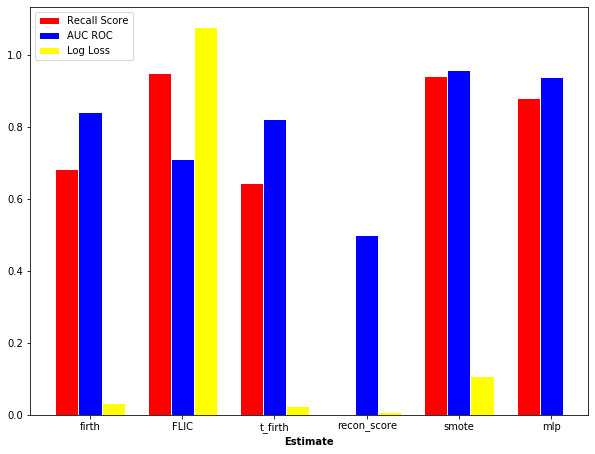

In [47]:
recalls = []
auc_rocs = []
log_losses =[]
for col in val_results.columns:
    recalls.append(recall_score(y_val,val_results[col].round()))
    auc_rocs.append(roc_auc_score(y_val,val_results[col].round()))
    log_losses.append(log_loss(y_val,val_results[col]))
    
estimators = list(val_results.columns)
width = 0.25

plt.figure(figsize=(10,7.5))
r1 = np.arange(len(recalls))
r2 = [i + width for i in r1]
r3 = [i + width for i in r2]

plt.bar(r1, recalls, color='red', width=width, edgecolor='white', label='Recall Score')
plt.bar(r2, auc_rocs, color='blue', width=width, edgecolor='white', label='AUC ROC')
plt.bar(r3, log_losses, color='yellow', width=width, edgecolor='white', label='Log Loss')

plt.xlabel('Estimate', fontweight='bold')
plt.xticks([i + width for i in range(len(recalls))], estimators)
plt.legend()


In [59]:
smote_train_results[:,0]

array([4.96164865e-05, 1.00000000e-06, 1.16454294e-02, ...,
       8.50469210e-01, 1.00000000e-06, 9.99999000e-01])

In [48]:
FLIC = PMLE.PMLE.Firth_Logit(num_iters=100,lr=0.05,FLIC=True, metric='recall_score', readout_rate=10)
train = np.zeros(X_train.shape[0])
val = np.zeros(X_val.shape[0])
for i in range(20):
    print('Epoch:',i+1)
    X = train_results[y_train==1].sample(frac=0.05).append(train_results[y_train==0].sample(frac=0.05))
    y = y_train.loc[X.index]
    FLIC.fit(X,y)
    train = ((i)*train + FLIC.predict_proba(train_results))/(i+1)
    val =  ((i)*val + FLIC.predict_proba(val_results))/(i+1)

Epoch: 1
Epoch 1 Recall: 1.0
Epoch 11 Recall: 1.0
Epoch 21 Recall: 0.75
Epoch 31 Recall: 0.6
Epoch 41 Recall: 0.6
Epoch 51 Recall: 0.6
Epoch 61 Recall: 0.6
Epoch 71 Recall: 0.6
Epoch 81 Recall: 0.6
Epoch 91 Recall: 0.6
Epoch: 2
Epoch 1 Recall: 1.0
Epoch 11 Recall: 1.0
Epoch 21 Recall: 1.0
Epoch 31 Recall: 1.0
Epoch 41 Recall: 1.0
Epoch 51 Recall: 1.0
Epoch 61 Recall: 1.0
Epoch 71 Recall: 1.0
Epoch 81 Recall: 1.0
Epoch 91 Recall: 1.0
Epoch: 3
Epoch 1 Recall: 1.0
Epoch 11 Recall: 1.0
Epoch 21 Recall: 1.0
Epoch 31 Recall: 1.0
Epoch 41 Recall: 1.0
Epoch 51 Recall: 1.0
Epoch 61 Recall: 1.0
Epoch 71 Recall: 1.0
Epoch 81 Recall: 1.0
Epoch 91 Recall: 1.0
Epoch: 4
Epoch 1 Recall: 1.0
Epoch 11 Recall: 1.0
Epoch 21 Recall: 1.0
Epoch 31 Recall: 1.0
Epoch 41 Recall: 1.0
Epoch 51 Recall: 1.0
Epoch 61 Recall: 1.0
Epoch 71 Recall: 1.0
Epoch 81 Recall: 1.0
Epoch 91 Recall: 1.0
Epoch: 5
Epoch 1 Recall: 1.0
Epoch 11 Recall: 1.0
Epoch 21 Recall: 1.0
Epoch 31 Recall: 1.0
Epoch 41 Recall: 1.0
Epoch 51 Recal

# Final validation set area under the ROC curve score

In [41]:
roc_auc_score(y_val,val)

0.9884146871274243